Note: Use this template to develop your project. Do not change the steps. For each step, you may add additional cells if needed.

#### Group Information

Group No: 15

- Member 1: Bernadette Lee Pei Chen
- Member 2: H'ng Sook Wern
- Member 3: Lim Chu En
- Member 4: Lim Wan Xuan



#### Import Libraries

In [1]:
%config Completer.use_jedi=False
import tensorflow as tf
import math
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version: ", tf.__version__)

tf.random.set_seed(42) # to get same sequence of random numbers across different run


TensorFlow version:  2.10.0


#### Load the dataset



In [2]:
dataset = pd.read_csv('classification_dataset.csv')
dataset.sample(10)

,f1,f2,f3,f4,f5,label
610,-6.859972,-15.663307,-0.583434,0.618841,0.258125,1
109,0.984928,2.669756,0.933650,11.102167,3.987146,1
827,0.665580,5.469129,1.314868,-6.386416,6.683482,0
628,-2.607356,4.734280,4.926534,12.517415,6.434871,1
334,-2.788583,2.784125,5.231011,11.686818,6.417750,1
716,5.064673,-5.806657,11.314134,3.803039,3.780178,1
923,-5.917825,3.399892,18.297383,0.171757,-0.201234,0
392,0.117614,-14.464385,8.827609,-6.221848,9.122022,1
765,2.931774,6.332732,3.029245,-3.199153,6.814118,0
936,1.975785,-4.468042,7.063273,4.437511,5.278694,1


In [3]:
dataset.shape

(1000, 6)

In [4]:
X = dataset.drop(columns = ['label'])
y = dataset['label']

print(X.shape)
print(y.shape)


(1000, 5)
(1000,)


#### Define the loss function



In [5]:
def loss_fn(y_test, y_pred):
    # Reshape the y_pred to one-dimensional tensor     
    y_pred = tf.reshape(y_pred,[-1])
    
    loss = - tf.reduce_mean((y_test * tf.math.log(y_pred)) + ((1 - y_test) * tf.math.log(1 - y_pred)))
    return loss

#### Define function to perform prediction

In [6]:
def sigmoid(x):
    exp = tf.math.exp(-x)
    return 1 / (1 + exp)

In [7]:
def relu(x):
    return tf.maximum(0.0, x)

In [8]:
def forward(inputs, weights, biases):

    weight_hidden, weight_output = weights
    bias_hidden, bias_output= biases

    inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
    
    inner_prdt = tf.matmul(inputs ,tf.transpose(weight_hidden)) + tf.transpose(bias_hidden)
    act_inner_prdt = relu(inner_prdt)
    
    output = tf.matmul(act_inner_prdt, tf.transpose(weight_output)) + bias_output
    act_output = sigmoid(output)

    return act_output

#### Define function for model training

Display the training and validation loss values for each epoch of the training loop. The displayed value must be in 6 decimal places.<br>
Hint: <br>
Use `tf.GradientTape` to compute the gradients.



In [9]:
def train(inputs, y_true, weights, biases, learning_rate, epochs, batch_size, val_data, patience):
    """ 
    This function performs the training using mini-batch gradient descent and implements early stopping.
    """
    best_weights = weights  # Initialize the best weights
    best_biases = biases  # Initialize the best biases
    min_loss = np.inf  # Initialize the minimum loss
    patience_cnt = 0  # Initialize patience counter

    # Lists to store loss values
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # For mini-batch gradient descent
        # Generates an array of indices in random order
        batch_idx = np.random.permutation(len(inputs))

        # Shuffle inputs and y_true
        inputs_shf = inputs[batch_idx]
        y_true_shf = y_true[batch_idx]
        
        # Call fit function for each epoch
        best_weights, best_biases, train_loss, val_loss = fit(inputs_shf, y_true_shf, weights, biases,
                                                              learning_rate, batch_size, val_data)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print out the training loss and validation loss for each epoch
        print("Epoch: ", epoch, " Training loss: ", train_loss.numpy(), " Validation loss: ", val_loss.numpy())

        # Round up the each value of validation loss to two decimal places
        val_loss = round(val_loss.numpy(), 2)

        # Early stopping
        if val_loss < min_loss:
            min_loss = val_loss
            patience_cnt = 0
        else:
            patience_cnt += 1
            if patience_cnt >= patience:
                print(f"Early stopping on epoch {epoch}")
                break

    return best_weights, best_biases, train_losses, val_losses


def fit(inputs, y_true, weights, biases, learning_rate, batch_size, val_data):
    """
    This function performs one epoch of training using mini-batch gradient descent.
    """
    epoch_loss = 0.0

    for i in range(0, len(inputs), batch_size):
        bth_inputs = inputs[i:i + batch_size]
        bth_y_true = y_true[i:i + batch_size]

        with tf.GradientTape() as tape:
            tape.watch(weights)
            tape.watch(biases)
            y_pred = forward(bth_inputs, weights, biases)  # Forward pass
            loss = loss_fn(bth_y_true, y_pred)  # Compute loss

        gradients = tape.gradient(loss, [weights, biases])  # Compute gradients


        # Update weights and biases
        weights[0] = weights[0] - learning_rate * gradients[0][0]
        weights[1] = weights[1] - learning_rate * gradients[0][1]
        biases[0] = biases[0] - learning_rate * gradients[1][0]
        biases[1] = biases[1] - learning_rate * gradients[1][1]

        epoch_loss += loss

    avg_epoch_loss = epoch_loss / (len(inputs) / batch_size)

    # Validation
    y_val_pred = forward(val_data[0], weights, biases)
    val_loss = loss_fn(val_data[1], y_val_pred)

    return weights, biases, avg_epoch_loss, val_loss


#### Define the tensors to hold the weights and biases (create the model)

Hint: <br>
Use `tf.Variable` to create the tensors.<br>
Put the tensors in a list.



In [10]:
# Define the number of neurons in each layer
input_size = 5 
hidden_size = 20  # Assuming hidden layer size is 20
output_size = 1  # Assuming output size is 1

# Define the weights and biases as tf.Variables
# Weights and biases for the hidden layer
weight_hidden = tf.Variable(tf.random.normal([hidden_size, input_size]), name='weight_hidden')
bias_hidden = tf.Variable(tf.zeros([hidden_size, 1]), name='bias_hidden')

# Weights and biases for the output layer
weight_output = tf.Variable(tf.random.normal([output_size, hidden_size]), name='weight_output')
bias_output = tf.Variable(tf.zeros([output_size, 1]), name='bias_output')

# Put the tensors in a list
weights = [weight_hidden, weight_output]
biases = [bias_hidden, bias_output]

#### Split the dataset
The ratio of training and test is 7:1:2.

In [11]:
from sklearn.model_selection import train_test_split

# training, validation and test ratio: 7:1:2

# Split the data in training and and test set first
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7) 

# For the test set, split the data so that 2/3 are test set and 1/3 are validation set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3)

# Print the shape for X and y of training, validation and test set
print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(700, 5)
(700,)
(100, 5)
(100,)
(200, 5)
(200,)


(None, None)

In [12]:
# Convert y_train, y_val and y_test to numpy array
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

#### Normalize the data



In [13]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the validation and test data using the scaler fitted on the training data
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape), print(y_train.shape)
print(X_val.shape), print(y_val.shape)
print(X_test.shape), print(y_test.shape)

(700, 5)
(700,)
(100, 5)
(100,)
(200, 5)
(200,)


(None, None)

#### Train the model

In [14]:
# Train the model with hyperparameter below
# learning_rate = 0.1
# epoch = 100
# batch_size = 500 (For mini batch gradient descent)
# patience = 5 (For early stopping regularization)
best_weights, best_biases, train_losses, val_losses = train(X_train, y_train, weights, biases, 0.1, 100, 500, (X_val, y_val), 5)

Epoch:  0  Training loss:  5.2390842  Validation loss:  3.1110363
Epoch:  1  Training loss:  3.865984  Validation loss:  2.233226
Epoch:  2  Training loss:  2.6738768  Validation loss:  1.6263348
Epoch:  3  Training loss:  1.8881066  Validation loss:  1.1971382
Epoch:  4  Training loss:  1.3997742  Validation loss:  0.8952988
Epoch:  5  Training loss:  1.0457753  Validation loss:  0.68691885
Epoch:  6  Training loss:  0.78200203  Validation loss:  0.554328
Epoch:  7  Training loss:  0.65229726  Validation loss:  0.4636137
Epoch:  8  Training loss:  0.51089483  Validation loss:  0.40620032
Epoch:  9  Training loss:  0.44840804  Validation loss:  0.36345345
Epoch:  10  Training loss:  0.39718738  Validation loss:  0.32997632
Epoch:  11  Training loss:  0.34102467  Validation loss:  0.30538806
Epoch:  12  Training loss:  0.33901295  Validation loss:  0.28364736
Epoch:  13  Training loss:  0.31118894  Validation loss:  0.26463425
Epoch:  14  Training loss:  0.284895  Validation loss:  0.24

#### Display the training loss and validation loss against epoch graph

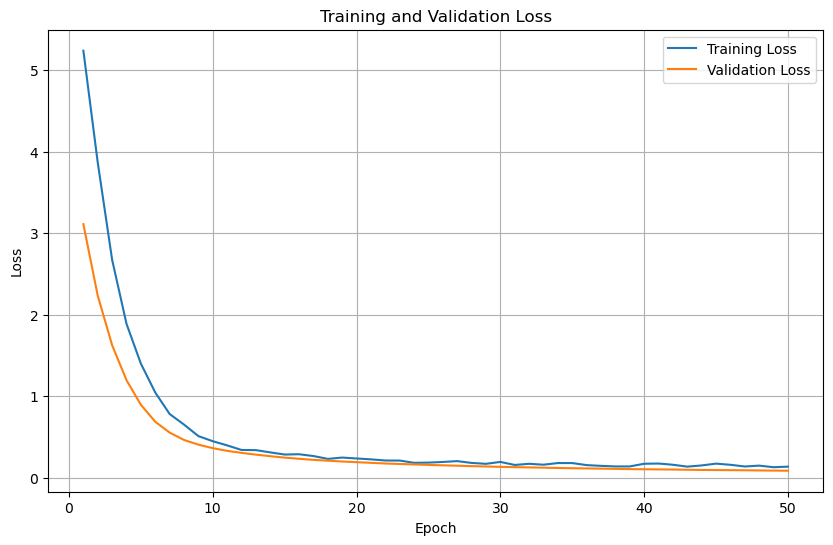

In [15]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Predict the test set

In [16]:
y_pred = forward(X_test, best_weights, best_biases)

#### Display the confusion matrix and the classification report.

In [17]:
from sklearn.metrics import confusion_matrix

# Apply thresholding to convert continuous predictions into binary class labels
y_pred_binary = tf.cast(tf.math.greater(y_pred, 0.5), tf.int32)

print(classification_report(y_test, y_pred_binary.numpy()))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary.numpy()))


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       103
           1       0.98      0.99      0.98        97

    accuracy                           0.98       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.98      0.99       200

Confusion Matrix:
 [[101   2]
 [  1  96]]
